In [1]:
import re
import pandas as pd
import numpy as np
from string import ascii_uppercase
import itertools
import random
import matplotlib.pyplot as plt

### Load data and preprocess

In [2]:
source_dir = "../data/fig1/"
source_file  = "kmeans_50_rep_50sec_variation.csv"

class InFile(object):
    """Process strings as the file is being loaded"""
    
    def __init__(self, infile):
        self.infile = open(infile)

    def __next__(self):
        return self.next()

    def __iter__(self):
        return self

    def read(self, *args, **kwargs):
        return self.__next__()

    def next(self):
        try:
            line = self.infile.readline()
            
            line = re.sub(r'  +', r',', line) 
            line = re.sub(r' ', r',', line) 

            return line
        except:
            self.infile.close()
            raise StopIteration

x = pd.read_csv(InFile(source_dir + source_file), header=0)

# Name specific columns
x.columns = range(8)
x.rename({0: "Use-Case", 4: "Runtime"}, axis=1, inplace=True)

x["timestamp"] = pd.to_datetime(x[1] + " " + x[2])

# The file has 50 records fo network A, followed by 50 records for network B, etc.
x["Network"] = list(itertools.chain(*[[el] * 50 for el in list(ascii_uppercase)]))[:len(x)]

hibench50 = x[["Use-Case", "Runtime", "timestamp", "Network"]]
print "Number of records:", len(hibench50)

hibench50.sample(10)

Number of records: 400


,Use-Case,Runtime,timestamp,Network
116,ScalaSparkKmeans,124.323,2019-03-10 03:13:58,C
141,ScalaSparkKmeans,120.767,2019-03-10 04:44:05,C
16,ScalaSparkKmeans,296.283,2019-03-09 18:51:13,A
394,ScalaSparkKmeans,183.510,2019-03-11 02:21:55,H
69,ScalaSparkKmeans,198.870,2019-03-10 00:09:52,B
71,ScalaSparkKmeans,155.954,2019-03-10 00:18:12,B
36,ScalaSparkKmeans,316.067,2019-03-09 21:10:50,A
317,ScalaSparkKmeans,204.788,2019-03-10 20:26:33,G
381,ScalaSparkKmeans,175.598,2019-03-11 01:21:06,H
230,ScalaSparkKmeans,145.361,2019-03-10 14:40:56,E


### Confidence Intervals: Estimation and Plotting 

In [3]:
def ci_p(s, p):
    """ 
    For values in the given array s and p in [0, 1], this fuction returns 
    empirical p-quantile value and its nonparametric 95% confidence interval.
    
    Refer to book by Boudec: https://infoscience.epfl.ch/record/146812/files/perfPublisherVersion_1.pdf,
    (Page 36 describes how nonparametric confidence intervals can be obtained for p-quantiles)
    """
    n = len(s)
    q = np.quantile(s, p)
    eta = 1.96 # for gamma = 0.95
    
    lo_rank = max(int(np.floor(n * p - eta * np.sqrt(n * p * (1-p)))), 0)
    hi_rank = min(int(np.ceil(n * p + eta * np.sqrt(n * p * (1-p))) + 1), n-1)
    
    s_sorted = sorted(s.tolist())
    q_ci_lo = s_sorted[lo_rank]
    q_ci_hi = s_sorted[hi_rank]
    
    return q, q_ci_lo, q_ci_hi

# Test for median
print ci_p(hibench50["Runtime"][:20], 0.5)

(297.9765, 282.392, 367.811)


In [4]:
# For each configuration, evaluate subsets of measurements 
lengths = [1,3,5,10,20]

# Evaluate this many partial subsets of measurements for each value in lengths
# (the higher this number, the longer it takes to process; for the paper, we used: 5000; run with 50 for a quick test)
trials = 50

# In addition to the median, test this p-quantile
p = 0.9

subset_eval = pd.DataFrame()
for n, grp in hibench50.groupby("Network"):
    
    # Most accurate estimates (for all 50 available measurements for each configuration)
    med, ci_lo, ci_hi = ci_p(np.array(grp["Runtime"].tolist()), 0.5)
    q, q_ci_lo, q_ci_hi = ci_p(np.array(grp["Runtime"].tolist()), p)
    accurate = {"Med": med, "CI Lo": ci_lo, "CI Hi": ci_hi, 
                "Q": q, "Q CI Lo": q_ci_lo, "Q CI Hi": q_ci_hi}
    
    subset = pd.DataFrame()
    for r in lengths:

        for t_idx in range(trials):
            
            # Select first r values from the shuffled list
            selection = grp["Runtime"].tolist()
            random.shuffle(selection)
            selection = selection[:r]
            
            med, ci_lo, ci_hi = ci_p(np.array(selection), 0.5)
            q, q_ci_lo, q_ci_hi = ci_p(np.array(selection), p)
            subset = pd.concat([subset, pd.DataFrame([{"Reps": r, "Med": med, "CI Lo": ci_lo, "CI Hi": ci_hi,
                                          "Q": q, "Q CI Lo": q_ci_lo, "Q CI Hi": q_ci_hi, "Comb": t_idx}])])
    
    subset["Rel Med Err"] = np.abs((subset["Med"] - accurate["Med"]) / accurate["Med"] * 100.0)
    subset["Rel Q Err"] = np.abs((subset["Q"] -accurate["Q"]) / accurate["Q"] * 100.0)
    subset["Network"] = n
    
    subset_eval = pd.concat([subset_eval, subset])

subset_eval.sample(10)

,CI Hi,CI Lo,Comb,Med,Q,Q CI Hi,Q CI Lo,Reps,Rel Med Err,Rel Q Err,Network
0,187.434,152.805,5,159.6165,189.5289,191.330,174.271,20,0.489087,0.629269,B
0,138.710,138.710,35,138.7100,138.7100,138.710,138.710,1,25.307271,40.653365,H
0,258.719,165.561,48,181.7110,243.3174,258.719,181.711,3,2.152040,4.102581,H
0,134.591,134.591,21,134.5910,134.5910,134.591,134.591,1,3.175583,4.533406,E
0,168.995,146.009,26,156.1740,187.6983,213.750,166.686,20,2.635270,1.589060,B
0,165.401,165.401,49,165.4010,165.4010,165.401,165.401,1,8.153672,18.763942,G
0,530.353,394.250,1,465.8800,526.5865,530.353,508.808,10,1.445425,0.790516,D
0,348.213,213.520,18,299.6700,338.5044,348.213,299.670,3,5.562357,15.045914,A
0,156.976,133.217,23,148.8270,156.7748,156.976,156.473,5,2.748436,8.721204,F
0,197.127,142.018,8,146.1360,189.6778,197.127,178.504,5,0.890601,10.435868,F


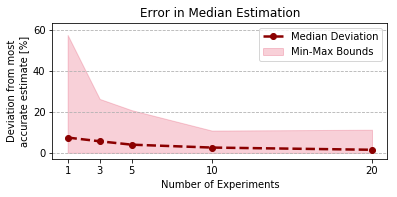

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(6, 2.5), sharex=True, sharey=True)

df_to_plot= subset_eval[["Reps", "Rel Med Err"]].groupby("Reps", as_index=False).agg(["median", "max", "min"])
df_l = len(df_to_plot)

ax.fill_between(df_to_plot.index.tolist(), 
                df_to_plot["Rel Med Err"]["min"].tolist(), 
                df_to_plot["Rel Med Err"]["max"].tolist(), 
                alpha=0.2, color="crimson", label="Min-Max Bounds")

ax.plot(df_to_plot.index.tolist(), 
        df_to_plot["Rel Med Err"]["median"].tolist(), 
        '--o', c='darkred', lw=2.5, label="Median Deviation")

# Additional styling
ax.grid(which='major', axis='y', linestyle='--')
ax.set_xlabel("Number of Experiments")
ax.set_ylabel("Deviation from most\naccurate estimate [%]")
ax.set_xticks(lengths)
ax.set_xticklabels(lengths)
ax.set_title("Error in Median Estimation")
ax.set_ylim([ax.set_ylim()[0], ax.set_ylim()[1]*1.05])
ax.legend();